In [ ]:
%env CUDA_VISIBLE_DEVICES=0


env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from random import shuffle
import math

from imutils import face_utils
import dlib
import pandas as pd
import json


import pickle

from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing

#from scipy.misc import imread, imresize

%matplotlib inline

In [3]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [4]:
ALL_DATA_DIR = 'C:/Users/윤영철/Desktop/ugrpTEST/sample/original/happiness'

INPUT_SIZE = (224, 224)
print(ALL_DATA_DIR)

C:/Users/윤영철/Desktop/ugrpTEST/sample/original/happiness


In [5]:
def rotate_image(image, landmarks):
    left_eye_x=left_eye_y=right_eye_x=right_eye_y=0
    for (x,y) in landmarks[36:41]:
        left_eye_x+=x
        left_eye_y+=y
    for (x,y) in landmarks[42:47]:
        right_eye_x+=x
        right_eye_y+=y
    left_eye_x/=6
    left_eye_y/=6
    right_eye_x/=6
    right_eye_y/=6
    theta=math.degrees(math.atan((right_eye_y-left_eye_y)/(right_eye_x-left_eye_x)))
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, theta, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    #print(left_eye_x, left_eye_y, right_eye_x, right_eye_y,theta,img.shape)
    return result


### 파일 읽기 

(1124, 1500, 3)


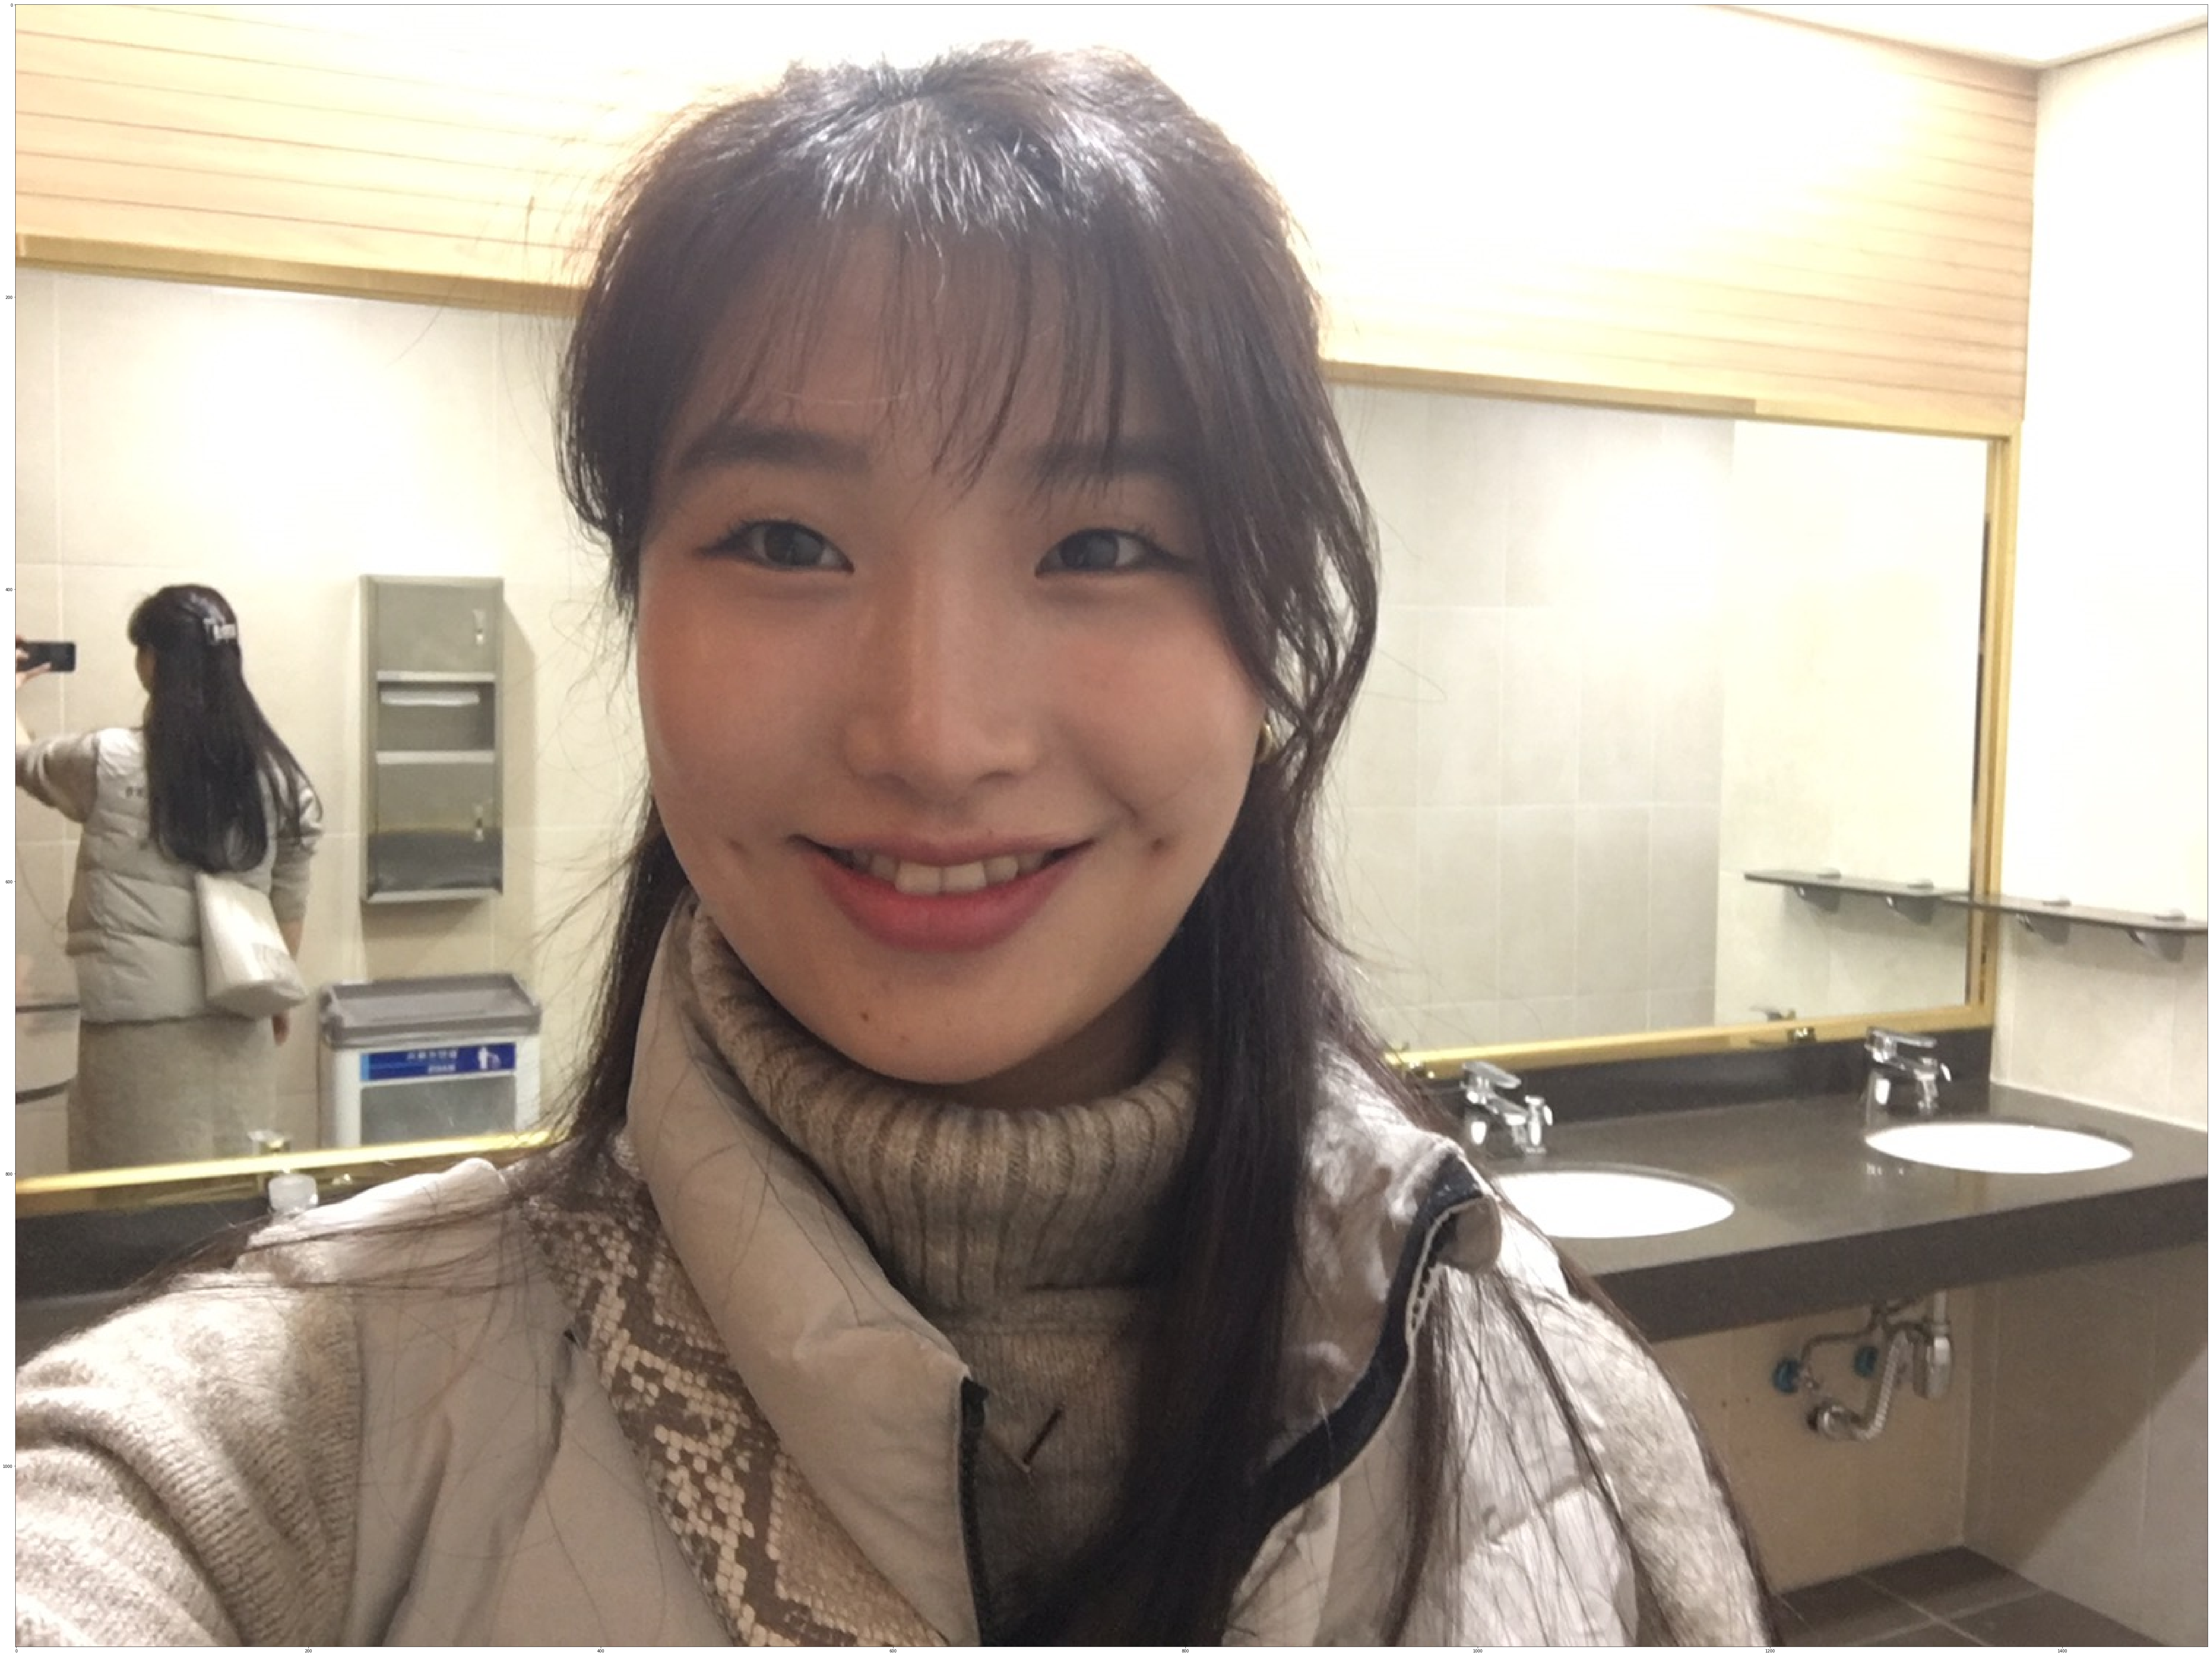

In [6]:
plt.figure(figsize=(100, 100))
s_i = "b.jpg"
k= "0cebc58b878df61c71de8e92bf181af059fe272b432e0ff5bab15d4aa12504f6_여_20_기쁨_공공시설_종교_의료시설_20201202161949-001-015.jpg"
img = cv2.imread("kk.jpg")
print(img.shape)

fix_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#img = cv2.cvtColor(s_i, cv2.COLOR_BGR2RGB)



#plt.imshow(img1)
#plt.imshow(img2)
plt.imshow(fix_img)



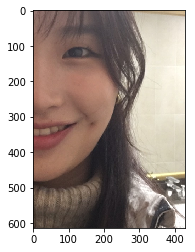

In [7]:
maxX = 1044.5197
maxY = 869.6799000000001
minX = 615.90533
minY = 255.37753000000004

dst = fix_img[int(minY):int(maxY),int(minX):int(maxX)].copy()

plt.imshow(dst)

In [8]:
with open("meta.json",'r') as f:
    json_data = json.load(f)
    print(json_data[0]["annot_A"]["boxes"])
#print(json.dumps(json_data))


{'maxX': 1044.5197, 'maxY': 869.6799000000001, 'minX': 615.90533, 'minY': 255.37753000000004}


### 랜드마크 추출 예시

[(399, 246) (861, 708)]


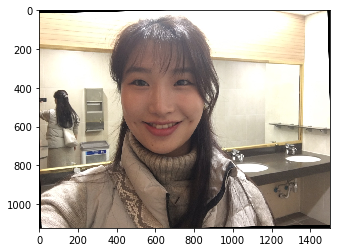

In [21]:

ALL = list(range(0, 68))
RIGHT_EYEBROW = list(range(17, 22))
LEFT_EYEBROW = list(range(22, 27))
RIGHT_EYE = list(range(36, 42))
LEFT_EYE = list(range(42, 48))
NOSE = list(range(27, 36))
MOUTH_OUTLINE = list(range(48, 61))
MOUTH_INNER = list(range(61, 68))
JAWLINE = list(range(0, 17))

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

#print(fix_img)

face_detector = detector(fix_img,1) #detecting face from the image 
print(face_detector[0])

landmarks = predictor(fix_img, face_detector[0])
landmarks_list = []

for p in landmarks.parts():
    landmarks_list.append([p.x, p.y])
    #cv2.circle(fix_img, (p.x,p.y), 1, (0,255,0),-1)
    
maxX = 1044.5197
maxY = 869.6799000000001
minX = 615.90533
minY = 255.37753000000004

dst = fix_img[int(minY):int(maxY),int(minX):int(maxX)].copy()

#plt.imshow(dst)

output = rotate_image(fix_img, landmarks_list)
plt.imshow(output)



### 랜드마크 추출 함수 

In [10]:
def create_landmark(image):
    ALL = list(range(0, 68))
    RIGHT_EYEBROW = list(range(17, 22))
    LEFT_EYEBROW = list(range(22, 27))
    RIGHT_EYE = list(range(36, 42))
    LEFT_EYE = list(range(42, 48))
    NOSE = list(range(27, 36))
    MOUTH_OUTLINE = list(range(48, 61))
    MOUTH_INNER = list(range(61, 68))
    JAWLINE = list(range(0, 17))

    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

    face_detector = detector(image,1) #detecting face from the image 

    landmarks = predictor(image, face_detector[0]) 
    landmarks_list = []

    for p in landmarks.parts():
        landmarks_list.append([p.x, p.y])
    
    return landmarks_list


rectangles[[(399, 246) (861, 708)]]
399 246 462 462


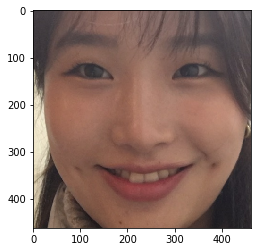

In [11]:

new = detector(output,1)
print(new)
for (i,rect) in enumerate(new):
    (x,y,w,h) = face_utils.rect_to_bb(rect)
print(x,y,w,h)
new_dst = output[y:(y+h),x:(x+w)].copy()
plt.imshow(new_dst)



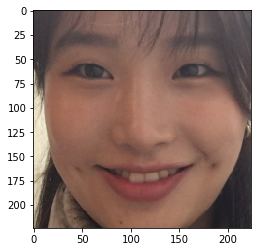

In [12]:
final = cv2.resize(new_dst,(224,224))
plt.imshow(final)

In [13]:
sample_metadata= []
for i in range(1,581):
    dic = {}
    dic["filename"] = "happy"+str(i)+".jpg"
    sample_metadata.append(dic)
#print(sample_metadata)

with open("C:\\Users\\User\\Desktop\\ugrpTEST\\happy\\meta_happy.json", 'w', encoding = 'utf-8') as make_file:
    json.dump(sample_metadata, make_file, indent = "\t")

In [19]:
with open("C:\\Users\\User\\Desktop\\ugrpTEST\\happy\\meta_happy.json",'r', encoding = "utf-8") as f:
    json_data = json.load(f)
    print(len(json_data))
    #print(json_data)
new_metadata = []

for i in range(89,len(json_data)):
    dic={}
    dic["filename"] = json_data[i]["filename"] #새로운 dic 에 추가 
    input_image = json_data[i]["filename"] 
    input_name = input_image 
    #print(str(input_image))
    input_image = cv2.imread("happy\\"+str(input_image))
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    
    landmarks_list = create_landmark(input_image) #landmark 생성
    rotated_image = rotate_image(input_image, landmarks_list) #생성된 랜드마크를 이용해서 rotate 
    
    cropped = detector(rotated_image,1) # 새로 rotate 한 image 의 얼굴 모양 추출 
    for (i,rect) in enumerate(cropped):
        (x,y,w,h) = face_utils.rect_to_bb(rect)
    output_image = rotated_image[y:(y+h),x:(x+w)].copy()
    output_image = cv2.resize(output_image,(224,224))
    output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

    cv2.imwrite("scaled_happy\\"+str(input_name), output_image)
    new_metadata.append(dic)





580


IndexError: 

In [ ]:
with open("C:\\Users\\User\\Desktop\\ugrpTEST\\scaled_happy\\meta_happy.json", 'w', encoding = 'utf-8') as make_file:
    json.dump(new_metadata, make_file, indent = "\t")
#print(json.dumps(json_data))